Upload an image (binary or grayscale preferred):


Saving WhatsApp Image 2026-02-02 at 5.14.48 PM.jpeg to WhatsApp Image 2026-02-02 at 5.14.48 PM (1).jpeg


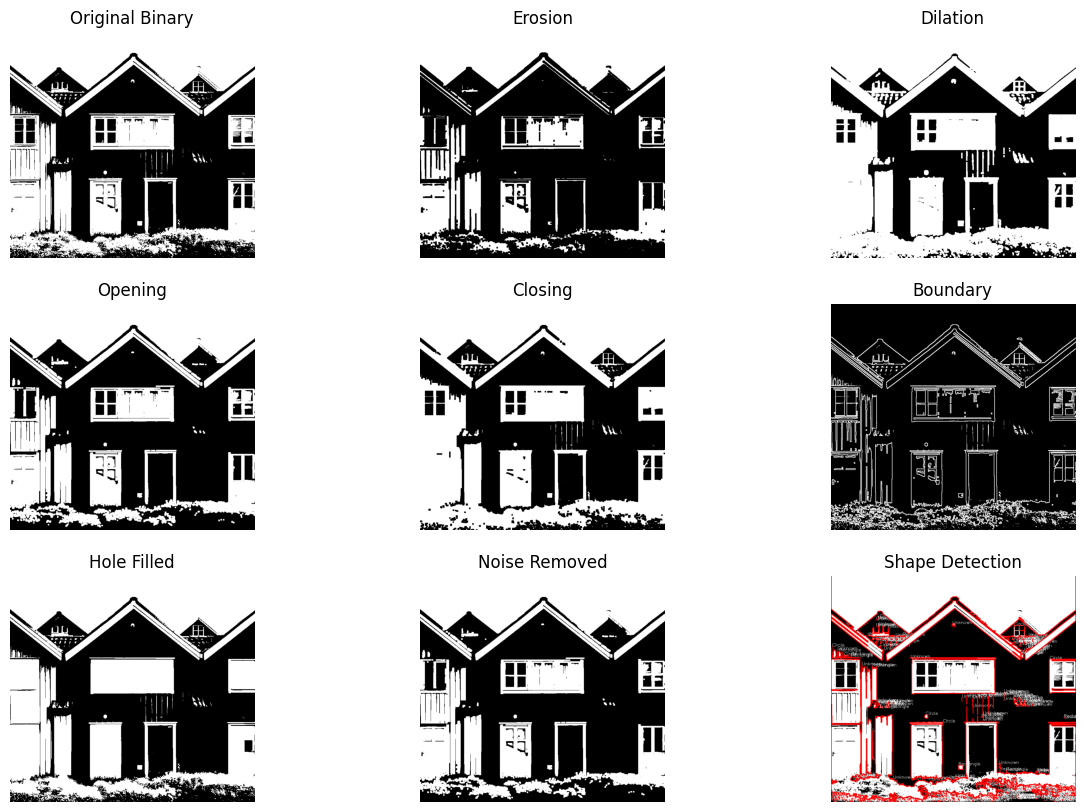

In [2]:
# ============================================
# MORPHOLOGICAL OPERATIONS - GOOGLE COLAB
# ============================================

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------
# IMAGE UPLOAD
# --------------------------------------------
print("Upload an image (binary or grayscale preferred):")
uploaded = files.upload()
image_name = list(uploaded.keys())[0]

# Read image
img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

# Convert to binary image
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Structuring Element
kernel = np.ones((5,5), np.uint8)

# --------------------------------------------
# 1. EROSION & DILATION
# --------------------------------------------
erosion = cv2.erode(binary, kernel, iterations=1)
dilation = cv2.dilate(binary, kernel, iterations=1)

# --------------------------------------------
# 2. OPENING & CLOSING
# --------------------------------------------
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# --------------------------------------------
# 3. BOUNDARY EXTRACTION
# Boundary = Original - Erosion
# --------------------------------------------
boundary = binary - erosion

# --------------------------------------------
# 4. HOLE FILLING USING RECONSTRUCTION
# --------------------------------------------
# Invert image
inv = cv2.bitwise_not(binary)

# Marker image
marker = np.zeros_like(inv)
marker[0, :] = inv[0, :]
marker[-1, :] = inv[-1, :]
marker[:, 0] = inv[:, 0]
marker[:, -1] = inv[:, -1]

# Reconstruction by dilation
prev = marker.copy()
while True:
    dilated = cv2.dilate(prev, kernel)
    reconstructed = cv2.min(dilated, inv)
    if np.array_equal(reconstructed, prev):
        break
    prev = reconstructed

filled = cv2.bitwise_not(reconstructed)

# --------------------------------------------
# 5. NOISE REMOVAL USING MORPHOLOGY
# --------------------------------------------
noise_removed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# --------------------------------------------
# 6. SHAPE DETECTION
# --------------------------------------------
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)

    if len(approx) == 3:
        shape = "Triangle"
    elif len(approx) == 4:
        shape = "Rectangle"
    elif len(approx) > 6:
        shape = "Circle"
    else:
        shape = "Unknown"

    cv2.drawContours(shape_img, [cnt], -1, (255,0,0), 2)
    x, y = approx[0][0]
    cv2.putText(shape_img, shape, (x, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

# --------------------------------------------
# DISPLAY RESULTS
# --------------------------------------------
titles = [
    "Original Binary", "Erosion", "Dilation",
    "Opening", "Closing", "Boundary",
    "Hole Filled", "Noise Removed", "Shape Detection"
]

images = [
    binary, erosion, dilation,
    opening, closing, boundary,
    filled, noise_removed, shape_img
]

plt.figure(figsize=(15,10))
for i in range(len(images)):
    plt.subplot(3,3,i+1)
    if len(images[i].shape) == 2:
        plt.imshow(images[i], cmap='gray')
    else:
        plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()